In [1]:
from __future__ import absolute_import, division, print_function

from pysymbolic.benchmarks.univariate_functions import *
from mpmath import *
from sympy import *

from pysymbolic.algorithms.symbolic_expressions import *
import numpy as np

from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')
import copy
from celluloid import Camera
from IPython.display import HTML
import mpmath
from pysymbolic.models.special_functions import MeijerG
from jax import grad, jit, vmap
import sys, os, time
import numpy as np
import pandas as pd
import scipy as sc
import itertools
from mpmath import *
from sympy import *
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from pysymbolic.models.special_functions import MeijerG
from pysymbolic.utilities.performance import compute_Rsquared

#from sympy.printing.theanocode import theano_function
from sympy.utilities.autowrap import ufuncify

from gplearn.genetic import SymbolicRegressor
from pathos.multiprocessing import ProcessingPool as Pool
import seaborn as sns
import pandas as pd
sns.set_style( "whitegrid" )

In [10]:
loss_list = []

def Optimize(Loss, theta_0):
    opt       = minimize(Loss, theta_0, method='CG', options={'xtol': 1e-6, 'disp': False,'maxiter':10})
    Loss_     = opt.fun
    theta_opt = opt.x
    
    return theta_opt, Loss_ 


def symbolic_modeling(f, G_order, theta_0, npoints, xrange,plot):
    global loss_list
    X         = np.linspace(xrange[0], xrange[1], npoints)
    def Loss(theta):
        global loss_list
        G     = MeijerG(theta=theta, order=G_order)
        loss_ = np.mean((f(X) - G.evaluate(X))**2)
        #print("Expression:", G.expression())
        loss_list.append(loss_)
        return loss_
    
    theta_opt, Loss_ = Optimize(Loss, theta_0)
    for idx,i in enumerate(loss_list):
        if i > 1:
            loss_list[idx] = 1
            
    symbolic_model   = MeijerG(theta=theta_opt, order=G_order)
    Loss_ = copy.deepcopy(loss_list)
    loss_list = []
    return symbolic_model, Loss_


def get_symbolic_model(f, npoints, xrange,hyperparameter_space,plot=False,higher_order=0):
    loss_threshold       = 10e-5

    symbol_exprs         = []
    losses_              = [] 
    increase_order = True
    for k in range(len(hyperparameter_space)):
        symbolic_model, Loss_ = symbolic_modeling(f, hyperparameter_space['hyper_'+str(k+1)][1], 
                                                  hyperparameter_space['hyper_'+str(k+1)][0], npoints, xrange,plot)
        symbol_exprs.append(symbolic_model)
        losses_.append(Loss_)
        for i in range(higher_order):
            symbolic_model.order[1:] = [ i+1 for i in symbolic_model.order[1:]]
            symbolic_model.theta = [1.0]+ list(symbolic_model.theta[:-1]) + [1.0] + [symbolic_model.theta[-1]]
            symbolic_model, Loss_ = symbolic_modeling(f, symbolic_model.order, 
                                                  symbolic_model.theta, npoints, xrange,plot)
            symbol_exprs.append(symbolic_model)
            losses_.append(Loss_)
    
    return losses_   

In [11]:
result_list = []
npoints = 100
xrange = [0.05, 0.95]
for func in [exponential_function,bessel_function,sinusoidal_function,rational_function]:
    print("Processing function: ",func)
    theta_1 = np.array([1.0,1.0]) + np.random.normal(loc=0.0, scale=1, size=(2))
    order_1 = [1,0,0,1]
    theta_2 = np.array([1.0,1.0,1.0,1.0]) + np.random.normal(loc=0.0, scale=1, size=(4))
    order_2 = [1,1,1,2]
    hyperparameter_space = {
                        'hyper_1': (theta_1, order_1),
                        'hyper_2': (theta_2, order_2)
                        #'hyper_1': (np.array([0.0,0.0,1.0,0.0,1.0]), [1,2,2,2]),
                        #'hyper_3': (np.array([2.0,2.0,2.0,1.0,1.0]), [0,1,3,1]),
                        #'hyper_4': (np.array([0.0,0.0,20.0]), [1,0,0,2])
                        }

    loss = get_symbolic_model(func, npoints, xrange,hyperparameter_space,plot=False,higher_order=0)

    #[plt.plot(i,label=str(idx)) for idx,i in enumerate(loss)]

    hyperparameter_space = {
                        'hyper_1': (theta_1, order_1),
                        #'hyper_2': (np.array([0.0,0.0,1.0,0.,1.0]), [1,2,2,2])
                        #'hyper_1': (np.array([0.0,0.0,1.0,0.0,1.0]), [1,2,2,2]),
                        #'hyper_3': (np.array([2.0,2.0,2.0,1.0,1.0]), [0,1,3,1]),
                        #'hyper_4': (np.array([0.0,0.0,20.0]), [1,0,0,2])
                        }


    loss_2 = get_symbolic_model(func, npoints, xrange,hyperparameter_space,plot=False,higher_order=1)
    result_list.append([[loss,loss_2]])

Processing function:  <function exponential_function at 0x10accc0d0>
Processing function:  <function bessel_function at 0x81d069840>
Processing function:  <function sinusoidal_function at 0x81d0697b8>
Processing function:  <function rational_function at 0x81d069730>


In [13]:
def smooth(x,smooth_coef = 0.9):
    smooth = x[0]
    for idx,i in enumerate(x):
        smooth = smooth_coef*smooth + (1-smooth_coef)*x[idx]
        x[idx] = smooth
    return x

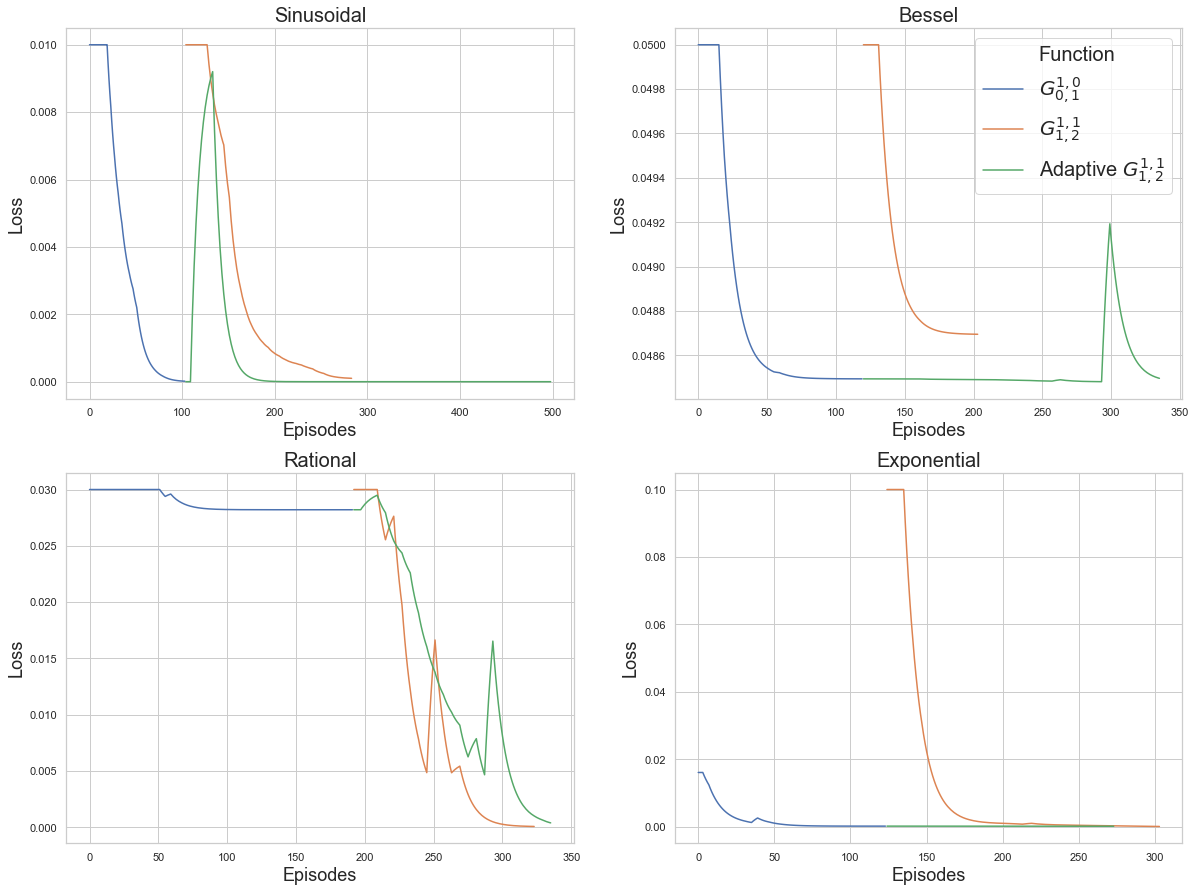

In [14]:
title_list = ["Sinusoidal","Bessel","Rational","Exponential"]
sns.set(font_scale=1)  # crazy big
sns.set_style( "whitegrid" )
cutoff_list = [0.01,0.05,0.03,0.1]
smooth_coef = 0.9
max_episodes = 200
plt.figure(figsize=(20,15))
for idx_r,result in enumerate(result_list):
    cutoff = cutoff_list[idx_r]
    plt.subplot(2,2,idx_r+1)
    for idx,i in enumerate(result):
        re = {"Episodes":[],"Loss":[],"Function":[]}

        tmp = np.array(result[idx][0][0][:])
        tmp[tmp > cutoff] = cutoff
        re["Loss"]+= list(smooth(tmp,smooth_coef=smooth_coef))
        l = len(list(tmp))
        re["Episodes"] += list(np.arange(l))
        re["Function"] += [r'$G_{0,1}^{1,0}$']*l
        acc_l = l 

        tmp = np.array(result[idx][0][1][:])
        tmp[tmp > cutoff] = cutoff
        l = len(list(tmp))
        re["Episodes"] += [i+acc_l for i in list(np.arange(l))]
        re["Loss"]+= list(smooth(tmp,smooth_coef=smooth_coef))
        re["Function"] += [r'$G_{1,2}^{1,1}$']*l

        tmp = np.array(result[idx][1][1][:])
        tmp[tmp > cutoff] = cutoff
        l = len(list(tmp))
        re["Episodes"] += [i+acc_l for i in list(np.arange(l))]
        re["Loss"]+= list(smooth(tmp,smooth_coef=smooth_coef))
        re["Function"] += [r'Adaptive $G_{1,2}^{1,1}$']*l

    df = pd.DataFrame(re)
    if idx_r == 1:
        b = sns.lineplot(x="Episodes", y="Loss",hue="Function", data=df)
        b.legend(fontsize=20)
    else:
        b = sns.lineplot(x="Episodes", y="Loss",hue="Function", data=df,legend=False)
    b.set_xlabel("Episodes",fontdict={'fontsize':18})
    b.set_ylabel("Loss",fontdict={'fontsize':18})
    plt.title(title_list[idx_r],fontdict={'fontsize':20})
    